In [12]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Classification Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Classification Metrics 
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

Cell 1: Markdown
---
## Feature Engineering
We'll prepare the data for modeling by:
1. Removing unnecessary columns
2. Encoding categorical variables  
3. Splitting features and target
4. Creating train/test split
5. Scaling features

In [2]:
# Load the dataset with correct path (one directory up from notebooks/)
df = pd.read_csv('../data/raw/Churn_Modelling.csv')
print(f"Shape: {df.shape}")

Shape: (10000, 14)


In [3]:
# Display first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Step 1: Drop columns that aren't useful for prediction
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
df_clean = df.drop(columns=columns_to_drop)
print(f"Shape after dropping columns: {df_clean.shape}")
print(f"Remaining columns: {list(df_clean.columns)}")

Shape after dropping columns: (10000, 11)
Remaining columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


In [5]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid modifying original data
df_encoded = df_clean.copy()

# Encode Geography (France, Spain, Germany)
le_geo = LabelEncoder()
df_encoded['Geography'] = le_geo.fit_transform(df_clean['Geography'])

# Encode Gender (Male, Female)
le_gender = LabelEncoder()
df_encoded['Gender'] = le_gender.fit_transform(df_clean['Gender'])

print("\nCategorical encoding complete!")
print(f"Geography mapping: {dict(zip(le_geo.classes_, le_geo.transform(le_geo.classes_)))}")
print(f"Gender mapping: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")


Categorical encoding complete!
Geography mapping: {'France': np.int64(0), 'Germany': np.int64(1), 'Spain': np.int64(2)}
Gender mapping: {'Female': np.int64(0), 'Male': np.int64(1)}


In [6]:
# Step 3: Split into features (X) and target (y)
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")

Features shape: (10000, 10)
Target shape: (10000,)

Feature columns: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [7]:
# Step 4: Split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 80% train, 20% test
    random_state=42     # For reproducibility
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 8000 samples
Test set: 2000 samples


In [8]:
# Step 5: Scale the features (standardization)
from sklearn.preprocessing import StandardScaler

# Create scaler and fit on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Feature scaling complete!
Training set shape: (8000, 10)
Test set shape: (2000, 10)


In [9]:
# Summary: Check class distribution in target variable
print("\n=== Target Variable Distribution ===")
print(f"Training set:")
print(y_train.value_counts())
print(f"\nTest set:")
print(y_test.value_counts())


=== Target Variable Distribution ===
Training set:
Exited
0    6356
1    1644
Name: count, dtype: int64

Test set:
Exited
0    1607
1     393
Name: count, dtype: int64


# Model Training

In [13]:
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    """
    Evaluate classification model performance
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # ROC-AUC score (if probability predictions available)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
    else:
        roc_auc = None
    
    return accuracy, precision, recall, f1, roc_auc

In [14]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(random_state=42, eval_metric='logloss'), 
    "CatBoost Classifier": CatBoostClassifier(verbose=False, random_state=42),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=42)
}

model_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

print("="*70)
print("MODEL EVALUATION RESULTS")
print("="*70)

for model_name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Get probability predictions for ROC-AUC (if available)
    try:
        y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    except:
        y_test_pred_proba = None
    
    # Evaluate Train and Test dataset
    train_acc, train_prec, train_rec, train_f1, _ = evaluate_model(y_train, y_train_pred)
    test_acc, test_prec, test_rec, test_f1, test_roc = evaluate_model(y_test, y_test_pred, y_test_pred_proba)
    
    # Store results
    model_list.append(model_name)
    accuracy_list.append(test_acc)
    precision_list.append(test_prec)
    recall_list.append(test_rec)
    f1_list.append(test_f1)
    
    # Print results
    print(f"\n{model_name}")
    print("-" * 70)
    print('Training Set Performance:')
    print(f"  - Accuracy:  {train_acc:.4f}")
    print(f"  - Precision: {train_prec:.4f}")
    print(f"  - Recall:    {train_rec:.4f}")
    print(f"  - F1 Score:  {train_f1:.4f}")
    
    print('\nTest Set Performance:')
    print(f"  - Accuracy:  {test_acc:.4f}")
    print(f"  - Precision: {test_prec:.4f}")
    print(f"  - Recall:    {test_rec:.4f}")
    print(f"  - F1 Score:  {test_f1:.4f}")
    if test_roc is not None:
        print(f"  - ROC-AUC:   {test_roc:.4f}")
    print("="*70)

print("\n✅ Model training complete!")

MODEL EVALUATION RESULTS

Logistic Regression
----------------------------------------------------------------------
Training Set Performance:
  - Accuracy:  0.8071
  - Precision: 0.6033
  - Recall:    0.1794
  - F1 Score:  0.2766

Test Set Performance:
  - Accuracy:  0.8155
  - Precision: 0.6000
  - Recall:    0.1832
  - F1 Score:  0.2807
  - ROC-AUC:   0.7636

K-Neighbors Classifier
----------------------------------------------------------------------
Training Set Performance:
  - Accuracy:  0.8779
  - Precision: 0.8143
  - Recall:    0.5255
  - F1 Score:  0.6388

Test Set Performance:
  - Accuracy:  0.8355
  - Precision: 0.6333
  - Recall:    0.3868
  - F1 Score:  0.4803
  - ROC-AUC:   0.7777

Decision Tree
----------------------------------------------------------------------
Training Set Performance:
  - Accuracy:  1.0000
  - Precision: 1.0000
  - Recall:    1.0000
  - F1 Score:  1.0000

Test Set Performance:
  - Accuracy:  0.7810
  - Precision: 0.4508
  - Recall:    0.5242
  - F

In [15]:
# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': model_list,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Sort by F1 Score
results_df = results_df.sort_values('F1 Score', ascending=False)

print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY (Sorted by F1 Score)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Find best model
best_model = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1 Score']
print(f"\n Best Model: {best_model} (F1 Score: {best_f1:.4f})")


MODEL COMPARISON SUMMARY (Sorted by F1 Score)
                   Model  Accuracy  Precision   Recall  F1 Score
     CatBoost Classifier    0.8665   0.735075 0.501272  0.596067
       Gradient Boosting    0.8660   0.755102 0.470738  0.579937
Random Forest Classifier    0.8640   0.742972 0.470738  0.576324
           XGBClassifier    0.8555   0.683099 0.493639  0.573117
     AdaBoost Classifier    0.8580   0.726141 0.445293  0.552050
           Decision Tree    0.7810   0.450766 0.524173  0.484706
  K-Neighbors Classifier    0.8355   0.633333 0.386768  0.480253
     Logistic Regression    0.8155   0.600000 0.183206  0.280702

 Best Model: CatBoost Classifier (F1 Score: 0.5961)


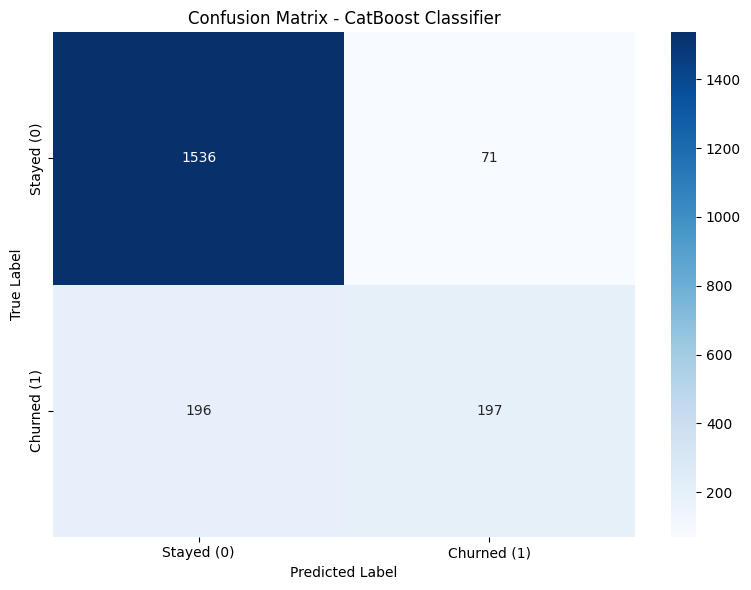


Classification Report:
              precision    recall  f1-score   support

      Stayed       0.89      0.96      0.92      1607
     Churned       0.74      0.50      0.60       393

    accuracy                           0.87      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



In [16]:
# Get the best model and show confusion matrix
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]

y_pred = best_model_obj.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stayed (0)', 'Churned (1)'],
            yticklabels=['Stayed (0)', 'Churned (1)'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Stayed', 'Churned']))